<a href="https://colab.research.google.com/github/NatSatie/mc886-final-project/blob/main/mc886_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project: Machine Learning MC886/MO444
### University of Campinas (UNICAMP), Institute of Computing (IC)

### Prof. Marcelo Reis, 2022s1

This project is under [GNU General Public License](https://www.gnu.org/licenses/gpl-3.0.html)

# How to download dataset

To download and run this notebook create a [Kaggle](https://www.kaggle.com/) account, once created go to `Account` and get an API token and download as `kaggle.json`.

To make sure to save properly your data, connect to your Google Drive account.

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 75 bytes


In [ ]:
!kaggle datasets download -d "misrakahmed/vegetable-image-dataset"

 98% 526M/534M [00:08<00:00, 79.8MB/s]
100% 534M/534M [00:08<00:00, 69.3MB/s]


In [ ]:
!unzip -qq vegetable-image-dataset.zip

# Pre-processing

After downloading the dataset, there's a pre-processing step to setup the image scale to 224 x 224 pixels. to improve the performance of other CNN's the data is augmented with Keras pre-processing tools from ImageGenerator.

In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionV3, MobileNet, ResNet50
import os, shutil
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_path = "../content/Vegetable Images/train"
validation_path = "../content/Vegetable Images/validation"
test_path = "../content/Vegetable Images/test"

image_categories = os.listdir(train_path)

# Image size default for 224 x 224, because of VG16, a convolutional neural network used in this experiment

image_value = 224
image_size=(image_value, image_value)
image_shape=(image_value, image_value, 3)
input_shape= [image_value, image_value, 3]

img_gen = ImageDataGenerator(rescale = 1.0/255.0)

train_image_generator = img_gen.flow_from_directory(
                                            train_path,
                                            target_size=image_size,
                                            batch_size=32,
                                            class_mode='categorical')


val_image_generator = img_gen.flow_from_directory(
                                            validation_path,
                                            target_size=image_size,
                                            batch_size=32,
                                            class_mode='categorical')


test_image_generator = img_gen.flow_from_directory(
                                            test_path,
                                            target_size=image_size,
                                            batch_size=32,
                                            class_mode='categorical')

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [ ]:
img_gen_augmented = ImageDataGenerator(
                                rescale = 1.0/255.0,
                                rotation_range=40,
                                horizontal_flip=True,
                                zoom_range=0.2,
                               )

train_image_generator_augmented = img_gen_augmented.flow_from_directory(
                                            train_path,
                                            target_size=image_size,
                                            batch_size=32,
                                            class_mode='categorical')


val_image_generator_augmented = img_gen_augmented.flow_from_directory(
                                            validation_path,
                                            target_size=image_size,
                                            batch_size=32,
                                            class_mode='categorical')


test_image_generator_augmented = img_gen_augmented.flow_from_directory(
                                            test_path,
                                            target_size=image_size,
                                            batch_size=32,
                                            class_mode='categorical')

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [ ]:
class_map = dict([(v, k) for k, v in train_image_generator.class_indices.items()])
print(class_map)

{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


# Basic functions

List of most common fuctions used in this project, such as plot accuracy, plot loss and plot convolutional network.

In [ ]:
def plotAccuracy(hist, activation):
    h = hist.history
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 5))
    plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
    plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')
    plt.xlabel("Number of Epochs")
    plt.legend(loc='best')
    plt.title("Modelo de treinamento com {} ".format(activation))
    plt.savefig("{}-accuracy.png".format(activation))
    plt.show()


def plotLoss(hist, activation):
    h = hist.history
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 5))
    plt.plot(h['loss'], c='red', label='Training Loss')
    plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.legend(loc='best')
    plt.title("Modelo de treinamento com {} ".format(activation))
    plt.savefig("{}-loss.png".format(activation))
    plt.show()

def plotHistory(hist, activation):
    plotAccuracy(hist, activation)
    plotLoss(hist, activation)

In [ ]:
epochs = 10

def train_model(model, optimizer, name, train_data):
  callbacks = [ keras.callbacks.EarlyStopping(patience=10),
                keras.callbacks.ModelCheckpoint('model_'+name+'.h5', 
                                                monitor='val_loss', 
                                                save_best_only=True),]
  if (optimizer == 'SGD'):
    model.compile(loss='categorical_crossentropy',
                  optimizer='SGD',
                  metrics=['accuracy'])
  else:
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='accuracy')
  hist = model.fit(train_data, 
                  epochs=epochs, 
                  verbose=1, 
                  validation_data=val_image_generator, 
                  steps_per_epoch = 15000//32, 
                  validation_steps = 3000//32, 
                  callbacks=callbacks)
  return model, hist

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plotConfusionMatrix(conf, title, mode):
  disp = ConfusionMatrixDisplay(conf)
  fig, ax = plt.subplots(figsize=(15, 15))
  disp.plot(ax=ax)
  plt.title(title)
  plt.savefig("{}-confusion.png".format(mode))
  plt.show()

# Data Visualization

This section is focused to show a small random sample of images from dataset.

In [ ]:
def plot_images(image_categories):
  plt.figure(figsize=(12, 12))
  for i, cat in enumerate(image_categories):
    image_path = train_path + '/' + cat
    images_in_folder = os.listdir(image_path)
    first_image_of_folder = images_in_folder[0]
    first_image_path = image_path + '/' + first_image_of_folder
    img = image.load_img(first_image_path)
    img_arr = image.img_to_array(img)/255.0
    plt.subplot(4, 4, i+1)
    plt.imshow(img_arr)
    plt.title(cat)
    plt.axis('off')
  plt.show()


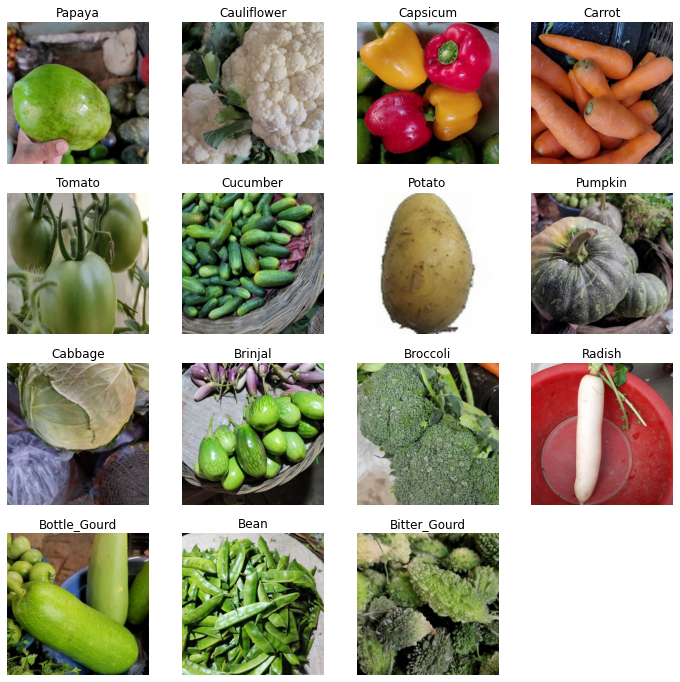

In [ ]:
plot_images(image_categories)

# First Training

A simple layered convolutional neural network, it's trained with a simple dataset without filters, and later there's a training with augmented data.

In [ ]:
def cnn_simple_model():
    model = Sequential([
      Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape),
      MaxPooling2D(2, ),
      Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape),
      MaxPooling2D(2, ),
      Conv2D(filters=126, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape),
      MaxPooling2D(2, ),
      Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape),
      MaxPooling2D(2, ),
      Flatten(),
      Dense(1024, activation='relu'),
      Dropout(0.25),
      Dense(15, activation='softmax')
    ])
    return model

model_cnn = cnn_simple_model()

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 126)       72702     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 126)      0

In [ ]:
model_cnn, hist_cnn = train_model(cnn_simple_model(), 'SGD', 'cnn', train_image_generator)

Epoch 1/10
468/468 [==============================] - 45s 91ms/step - loss: 2.1576 - accuracy: 0.2843 - val_loss: 2.2563 - val_accuracy: 0.2765
Epoch 2/10
468/468 [==============================] - 42s 89ms/step - loss: 1.2610 - accuracy: 0.5863 - val_loss: 0.8319 - val_accuracy: 0.7396
Epoch 3/10
468/468 [==============================] - 40s 86ms/step - loss: 0.7658 - accuracy: 0.7531 - val_loss: 0.5434 - val_accuracy: 0.8202
Epoch 4/10
468/468 [==============================] - 41s 87ms/step - loss: 0.4590 - accuracy: 0.8539 - val_loss: 0.3303 - val_accuracy: 0.8955
Epoch 5/10
468/468 [==============================] - 41s 87ms/step - loss: 0.2671 - accuracy: 0.9205 - val_loss: 0.1854 - val_accuracy: 0.9466
Epoch 6/10
468/468 [==============================] - 40s 86ms/step - loss: 0.1555 - accuracy: 0.9539 - val_loss: 0.2905 - val_accuracy: 0.9143
Epoch 7/10
468/468 [==============================] - 40s 86ms/step - loss: 0.0847 - accuracy: 0.9747 - val_loss: 0.1667 - val_accuracy:

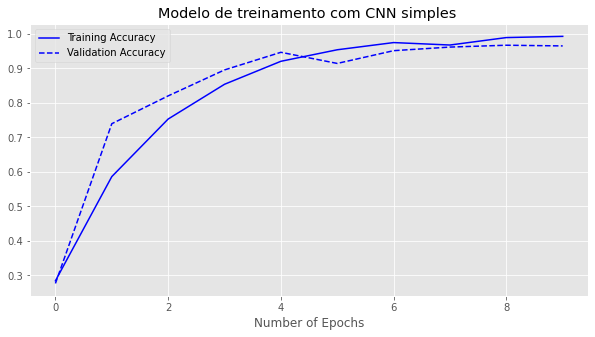

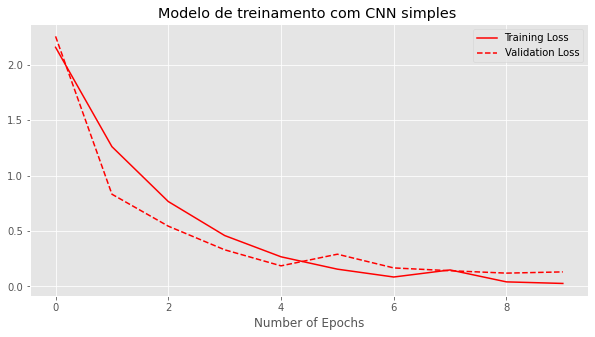

In [ ]:
plotHistory(hist_cnn, "CNN simples")

In [ ]:
model_cnn_augmented, hist_cnn_augmented = train_model(cnn_simple_model(), 'SGD', 'cnn_augmented', train_image_generator_augmented)

Epoch 1/10
468/468 [==============================] - 174s 370ms/step - loss: 2.2057 - accuracy: 0.2574 - val_loss: 1.5402 - val_accuracy: 0.4896
Epoch 2/10
468/468 [==============================] - 175s 374ms/step - loss: 1.5492 - accuracy: 0.4750 - val_loss: 1.2295 - val_accuracy: 0.5796
Epoch 3/10
468/468 [==============================] - 173s 370ms/step - loss: 1.2609 - accuracy: 0.5782 - val_loss: 0.9983 - val_accuracy: 0.6761
Epoch 4/10
468/468 [==============================] - 174s 372ms/step - loss: 0.9705 - accuracy: 0.6774 - val_loss: 0.6878 - val_accuracy: 0.7853
Epoch 5/10
468/468 [==============================] - 173s 370ms/step - loss: 0.7334 - accuracy: 0.7587 - val_loss: 0.4813 - val_accuracy: 0.8569
Epoch 6/10
468/468 [==============================] - 173s 370ms/step - loss: 0.5616 - accuracy: 0.8179 - val_loss: 0.7172 - val_accuracy: 0.7544
Epoch 7/10
468/468 [==============================] - 172s 367ms/step - loss: 0.4149 - accuracy: 0.8648 - val_loss: 0.2322 -

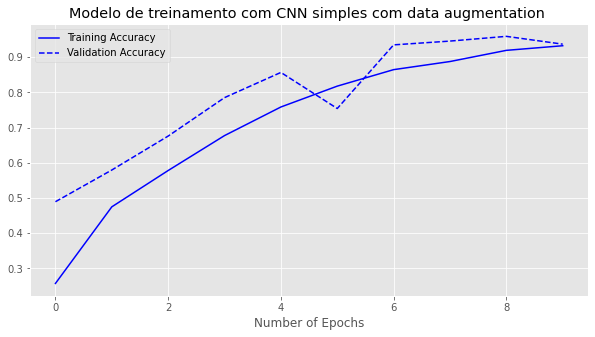

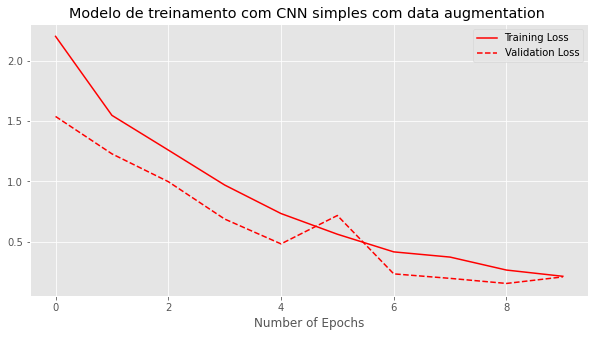

In [ ]:
plotHistory(hist_cnn_augmented, "CNN simples com data augmentation")

# Transfer learning

This is a sequence of many training with various convolutional neural network architectures, such as InceptionV3, VGG16, ResNet and MobileNet.

In [ ]:
def cnn_transfer_learning_model(model_base):
  if (model_base=='inception'):
    pre_trained_model = InceptionV3(input_shape=image_shape, include_top = False, weights="imagenet")
  elif (model_base=='vgg16'):
    pre_trained_model = VGG16(input_shape=image_shape, include_top = False, weights="imagenet", classes=15,classifier_activation="softmax")
  elif (model_base=='mobilenet'):
    pre_trained_model = MobileNet(input_shape=image_shape, include_top = False, weights="imagenet", classes=15,classifier_activation="softmax")
  elif (model_base=='resnet'):
    pre_trained_model = ResNet50(input_shape=image_shape, include_top = False, weights="imagenet", classes=15,classifier_activation="softmax")
  model = Sequential([
      pre_trained_model,
      Flatten(),
      Dense(1024, activation='relu'),
      Dropout(0.25),
      Dense(15, activation='softmax')
  ])
  return model

## Inception V3

In [ ]:
model_v3, hist_v3 = train_model(cnn_transfer_learning_model('inception')
                                            , 'SGD', 'inceptionv3', train_image_generator)

87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/10
468/468 [==============================] - 86s 170ms/step - loss: 0.2063 - accuracy: 0.9446 - val_loss: 0.0450 - val_accuracy: 0.9869
Epoch 2/10
468/468 [==============================] - 78s 167ms/step - loss: 0.0142 - accuracy: 0.9962 - val_loss: 0.0079 - val_accuracy: 0.9980
Epoch 3/10
468/468 [==============================] - 78s 166ms/step - loss: 0.0067 - accuracy: 0.9983 - val_loss: 0.0036 - val_accuracy: 0.9997
Epoch 4/10
468/468 [==============================] - 78s 166ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.0054 - val_accuracy: 0.9993
Epoch 5/10
468/468 [==============================] - 77s 164ms/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 0.0056 - val_accuracy: 0.9993
Epoch 6/10
468/468 [==============================] - 77s 165ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0048 - val_accuracy: 0.9987
Epoch 7/10
468/468 [==============================] - 77s 164ms/s

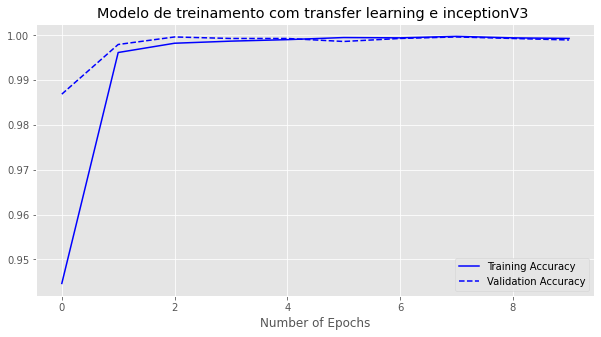

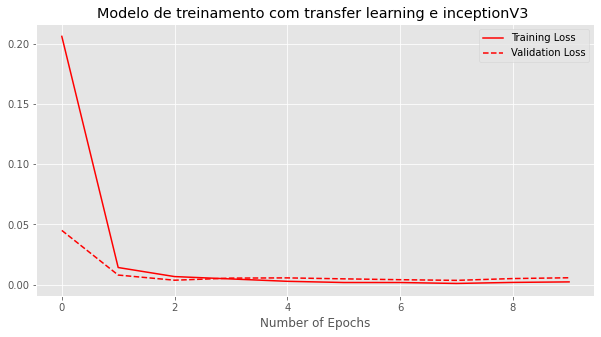

In [ ]:
plotHistory(hist_v3, "transfer learning e inceptionV3")

In [ ]:
model_v3_augmented, hist_v3_augmented = train_model(cnn_transfer_learning_model('inception')
                                            , 'SGD', 'inceptionv3_augmented', train_image_generator)

Epoch 1/10
124/468 [======>.......................] - ETA: 51s - loss: 0.6058 - accuracy: 0.8440

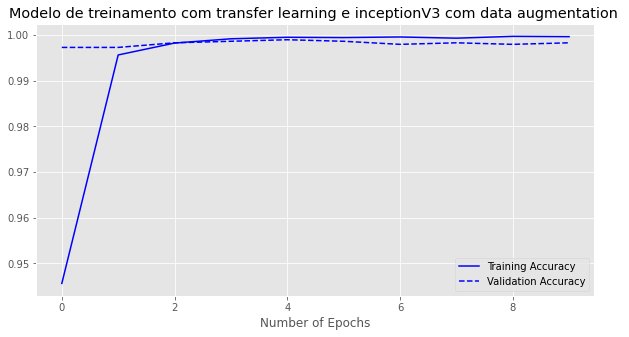

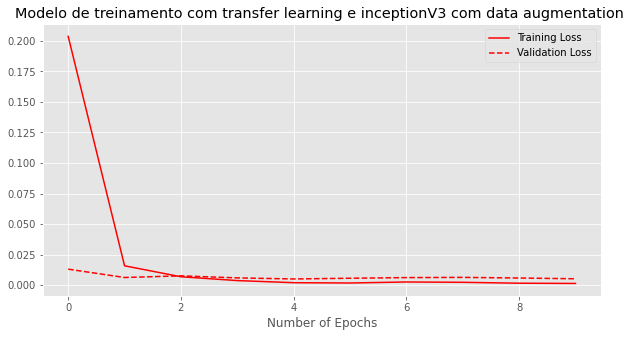

In [ ]:
plotHistory(hist_v3_augmented, "transfer learning e inceptionV3 com data augmentation")

## VGG16

In [ ]:
epochs = 10

In [ ]:
model_vgg16, hist_vgg16 = train_model(cnn_transfer_learning_model('vgg16')
                                            , 'SGD', 'vgg16', train_image_generator)

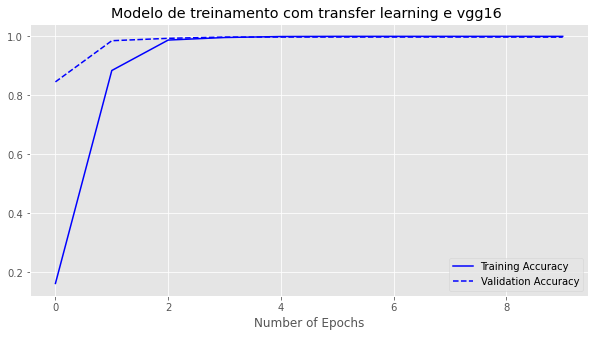

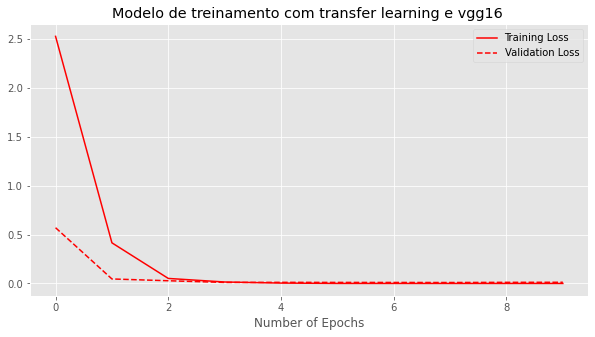

In [ ]:
plotHistory(hist_vgg16, "transfer learning e vgg16")

In [ ]:
model_vgg16_augmented, hist_vgg16_augmented = train_model(cnn_transfer_learning_model('vgg16')
                                            , 'SGD', 'vgg16_augmented', train_image_generator_augmented)

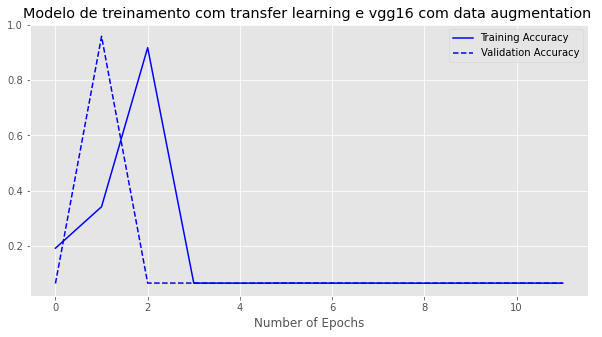

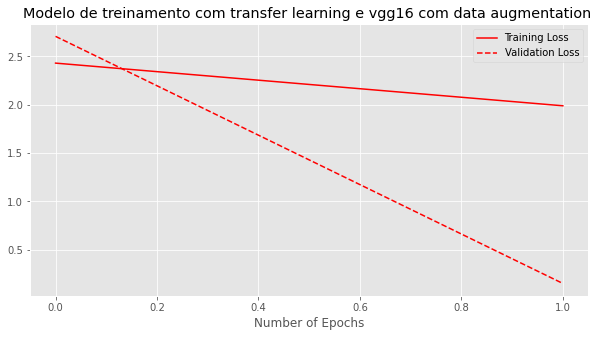

In [ ]:
plotHistory(hist_vgg16_augmented, "transfer learning e vgg16 com data augmentation")

## MobileNet

In [ ]:
model_mobile, hist_mobile = train_model(cnn_transfer_learning_model('mobilenet')
                                            , 'SGD', 'mobilenet', train_image_generator)

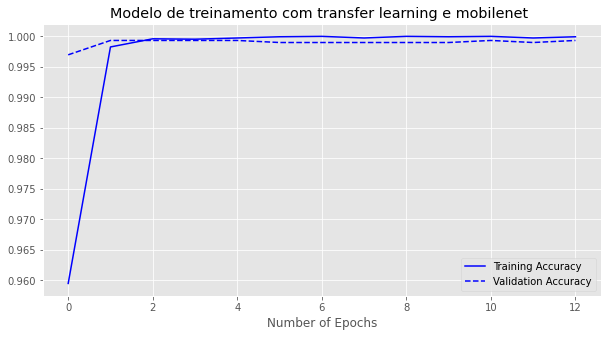

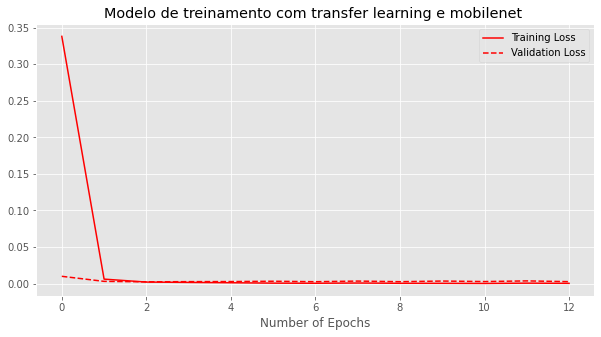

In [ ]:
plotHistory(hist_mobile, "transfer learning e mobilenet")

In [ ]:
model_mobile_augmented, hist_mobile_augmented = train_model(cnn_transfer_learning_model('mobilenet')
                                            , 'SGD', 'mobilenet_augmented', train_image_generator_augmented)

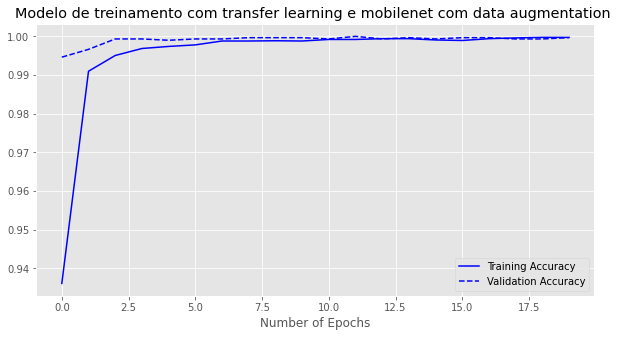

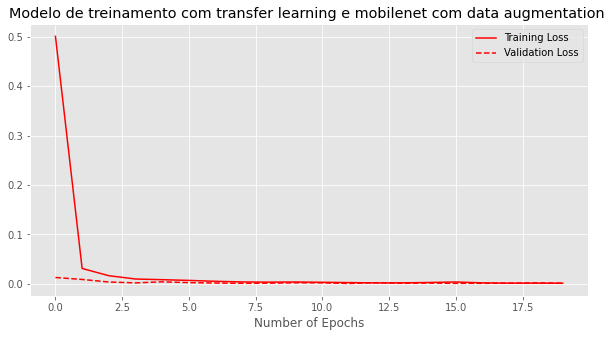

In [ ]:
plotHistory(hist_mobile_augmented, "transfer learning e mobilenet com data augmentation")

## ResNet

In [ ]:
model_resnet, hist_resnet = train_model(cnn_transfer_learning_model('resnet')
                                            , 'SGD', 'resnet', train_image_generator)

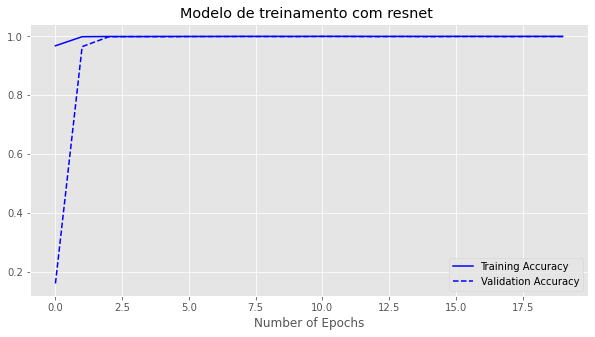

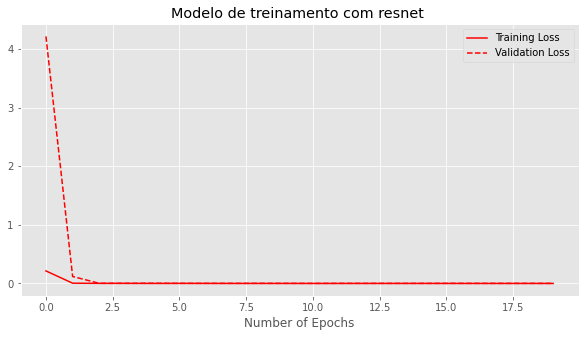

In [ ]:
plotHistory(hist_resnet, "resnet")

In [ ]:
model_resnet_augmented, hist_resnet_augmented = train_model(cnn_transfer_learning_model('resnet')
                                            , 'SGD', 'resnet_augmented', train_image_generator_augmented)

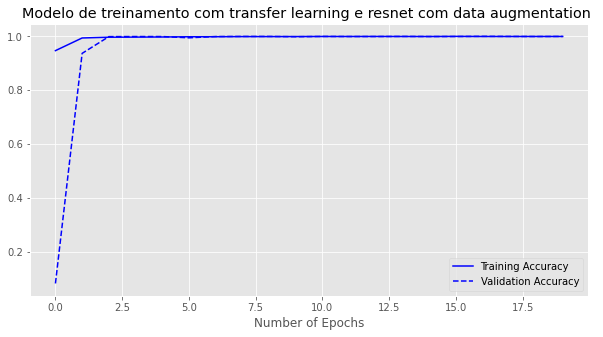

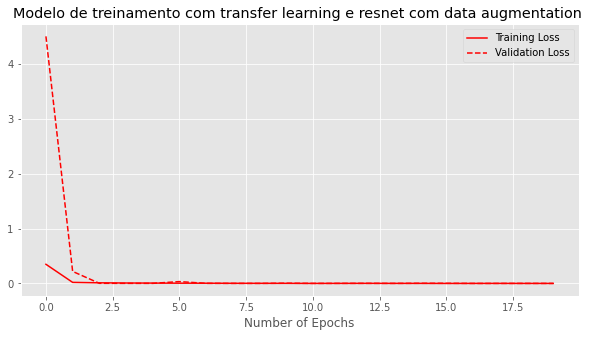

In [ ]:
plotHistory(hist_resnet_augmented, "transfer learning e resnet com data augmentation")

# Import previous training


To prevent great delays to train all over again, you can import all the models from training results. You can download and import for your project [here](https://drive.google.com/drive/folders/11F4jwCVIjdRXhZNhinbH5i622uuP32gS?usp=sharing).

In [ ]:
model_path = '/content/drive/MyDrive/MC886-RESULTS/model/'
# model_cnn    = keras.models.load_model( model_path+'model_cnn.h5')
# model_v3     = keras.models.load_model( model_path+'model_inceptionv3.h5')
# model_vgg16  = keras.models.load_model( model_path+'model_vgg16.h5')
# model_mobile = keras.models.load_model( model_path+'model_mobilenet.h5')
# model_resnet = keras.models.load_model( model_path+'model_resnet.h5')

In [ ]:
# model_cnn_augmented    = keras.models.load_model( model_path+'model_cnn_augmented.h5')
# model_v3_augmented     = keras.models.load_model( model_path+'model_inceptionv3_augmented.h5')
# model_vgg16_augmented  = keras.models.load_model( model_path+'model_vgg16_augmented.h5')
# model_mobile_augmented = keras.models.load_model( model_path+'model_mobilenet_augmented.h5')
# model_resnet_augmented = keras.models.load_model( model_path+'model_resnet_augmented.h5')

# Analysis with confusion matrix

The confusion matrix is essencial to evaluate the CNN's performance. 

In [ ]:
import cv2
import os

img_path = "../content/Vegetable Images/test/"

bean_path = img_path + "Bean"
bitter_gourd_path = img_path + "Bitter_Gourd"
bottle_gourd_path = img_path + "Bottle_Gourd"
brinjal_path = img_path + "Brinjal"
broccoli_path = img_path + "Broccoli"
cabbage_path = img_path + "Cabbage"
capsicum_path = img_path + "Capsicum"
carrot_path = img_path + "Carrot"
cauliflower_path = img_path + "Cauliflower"
cucumber_path = img_path + "Cucumber"
papaya_path = img_path + "Papaya"
potato_path = img_path + "Potato"
pumpkin_path = img_path + "Pumpkin"
radish_path = img_path + "Radish"
tomato_path = img_path + "Tomato"

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        test_img = image.load_img(os.path.join(folder,filename), target_size=(224, 224))
        test_img_arr = image.img_to_array(test_img)/255.0
        test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))
        if test_img is not None:
            images.append(test_img_input)
    return images

In [ ]:
img_arr = [
             load_images_from_folder(bean_path),
             load_images_from_folder(bitter_gourd_path),
             load_images_from_folder(bottle_gourd_path),
             load_images_from_folder(brinjal_path),
             load_images_from_folder(broccoli_path),
             load_images_from_folder(cabbage_path),
             load_images_from_folder(capsicum_path),
             load_images_from_folder(carrot_path),
             load_images_from_folder(cauliflower_path),
             load_images_from_folder(cucumber_path),
             load_images_from_folder(papaya_path),
             load_images_from_folder(potato_path),
             load_images_from_folder(pumpkin_path),
             load_images_from_folder(radish_path),
             load_images_from_folder(tomato_path),
]

In [ ]:
def generate_predictions(model):
  res = []
  for arr in img_arr:
    new_pred = []
    for j in arr:
      new_pred.append(np.argmax(model.predict(j)))
    res.append(new_pred)
  return res

In [ ]:
def createConfusionMatrix(predicted):
  conf_matrix= np.zeros((15, 15))
  for i, arr in zip(class_map, predicted):
    for j in arr:
      conf_matrix[i][j] += 1
  return conf_matrix

In [ ]:
predicted_cnn = generate_predictions(model_cnn)
predicted_v3 = generate_predictions(model_v3)
predicted_vgg16 = generate_predictions(model_vgg16)
predicted_mobile = generate_predictions(model_mobile)
predicted_resnet = generate_predictions(model_resnet)

In [ ]:
predicted_cnn_augmented = generate_predictions(model_cnn_augmented)
predicted_v3_augmented = generate_predictions(model_v3_augmented)
predicted_vgg16_augmented = generate_predictions(model_vgg16_augmented)
predicted_mobile_augmented = generate_predictions(model_mobile_augmented)
predicted_resnet_augmented = generate_predictions(model_resnet_augmented)

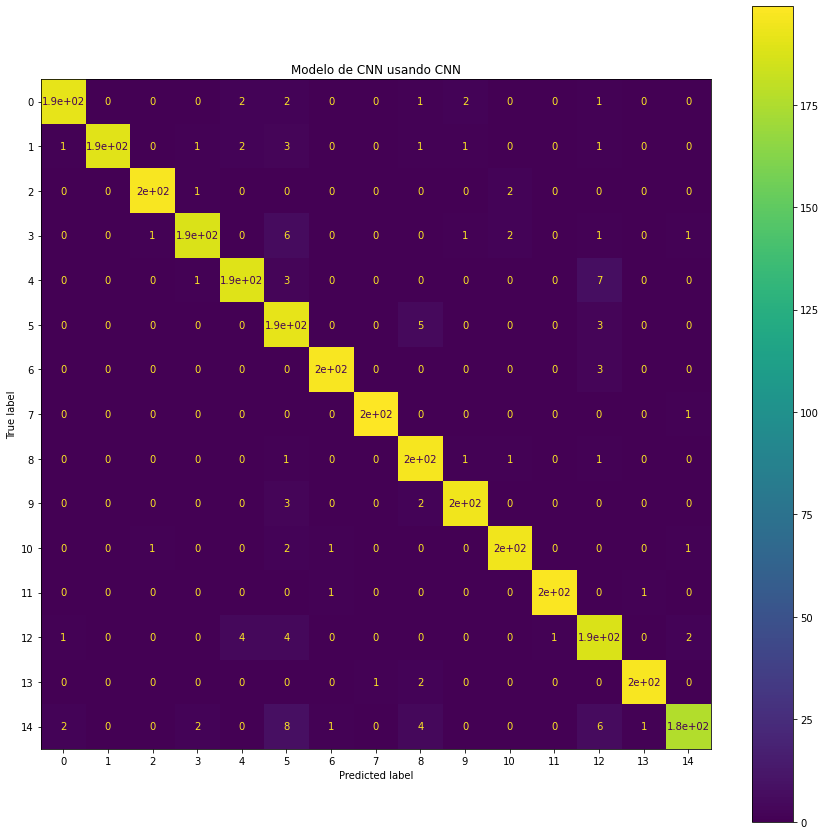

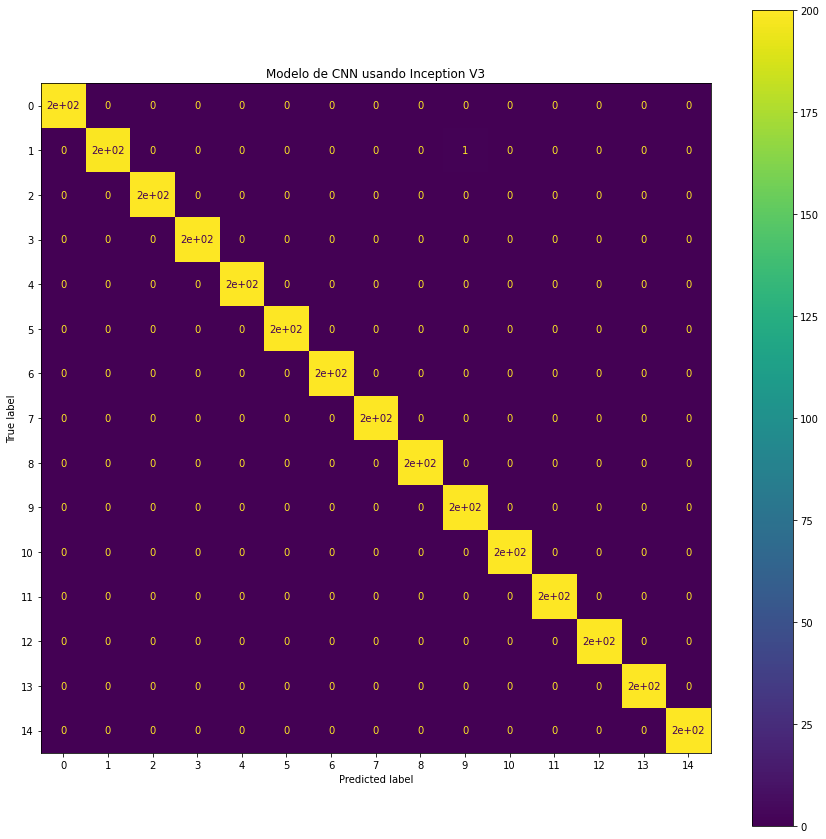

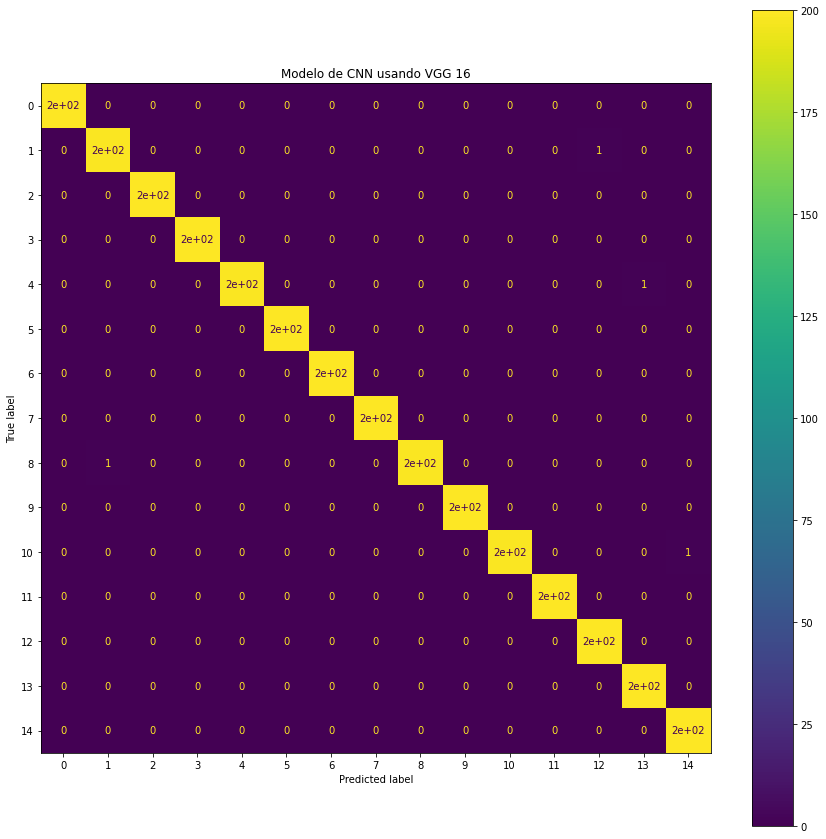

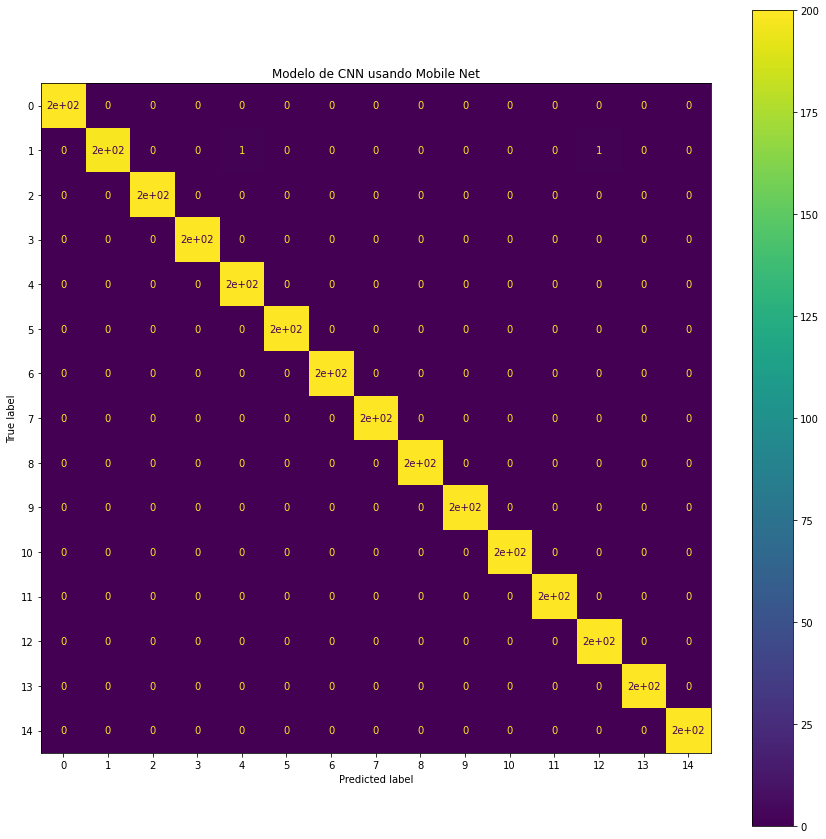

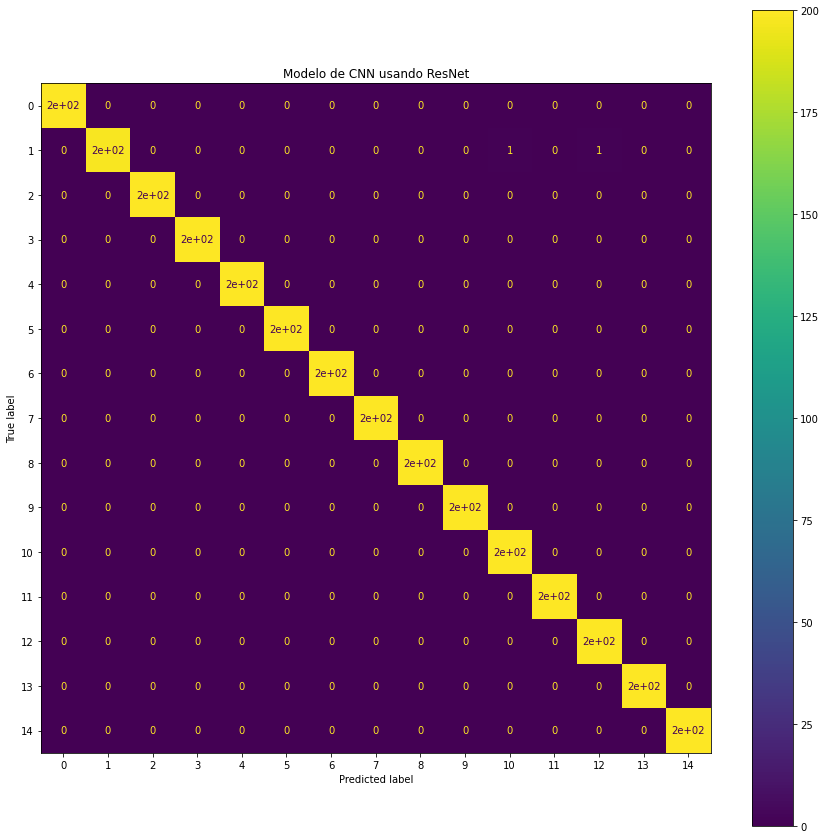

In [ ]:
plotConfusionMatrix(createConfusionMatrix(predicted_cnn), "Modelo de CNN usando CNN", 'cnn')
plotConfusionMatrix(createConfusionMatrix(predicted_v3), "Modelo de CNN usando Inception V3", 'v3')
plotConfusionMatrix(createConfusionMatrix(predicted_vgg16), "Modelo de CNN usando VGG 16", 'vgg16')
plotConfusionMatrix(createConfusionMatrix(predicted_mobile), "Modelo de CNN usando Mobile Net", 'mobile')
plotConfusionMatrix(createConfusionMatrix(predicted_resnet), "Modelo de CNN usando ResNet", 'resnet')

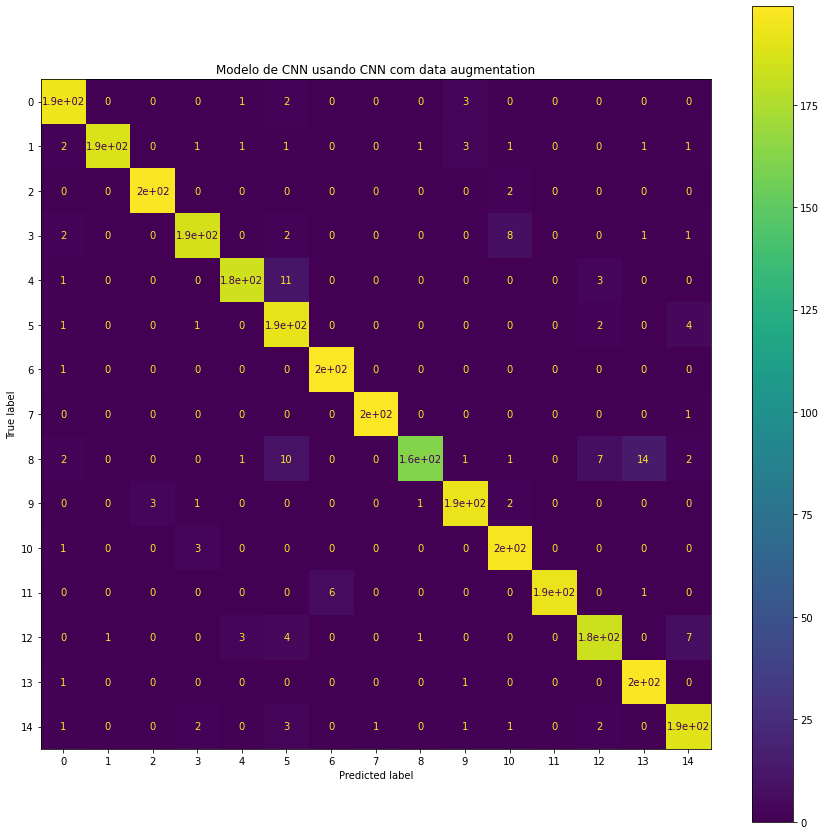

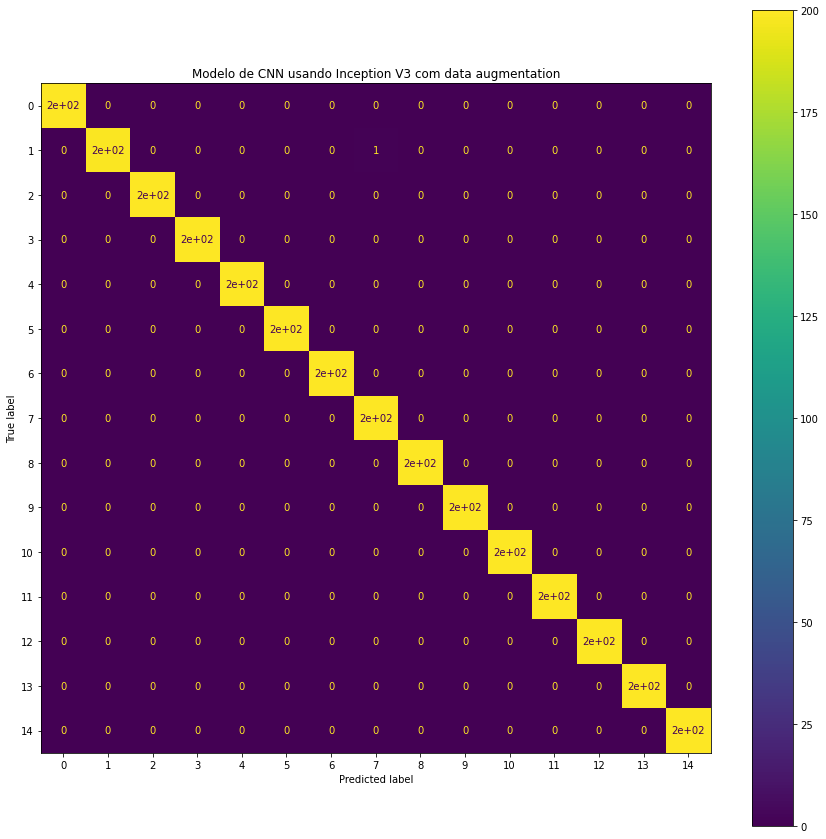

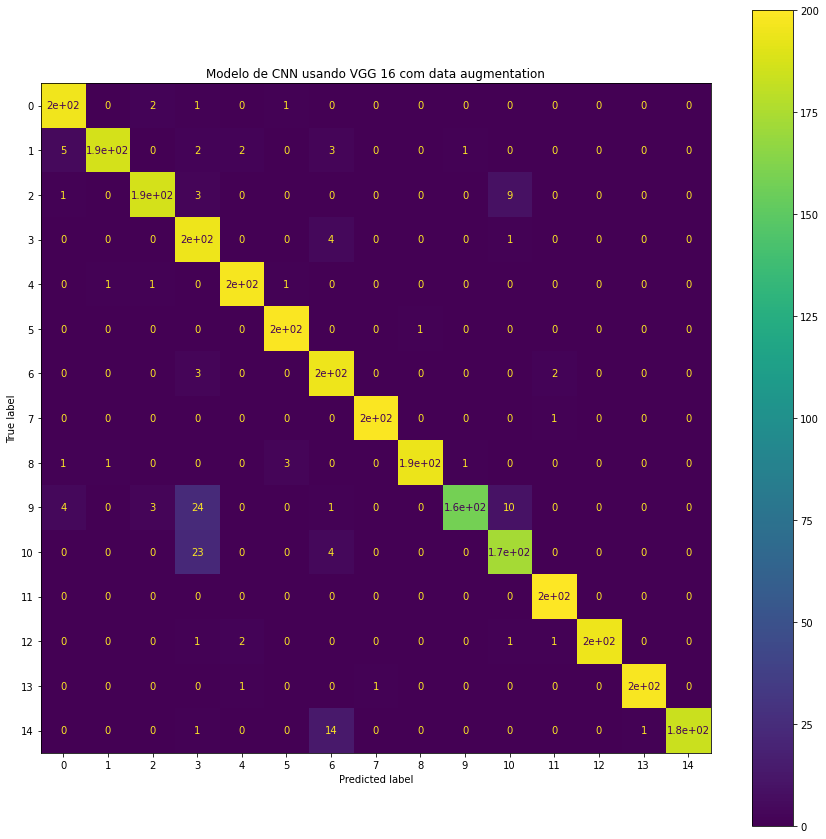

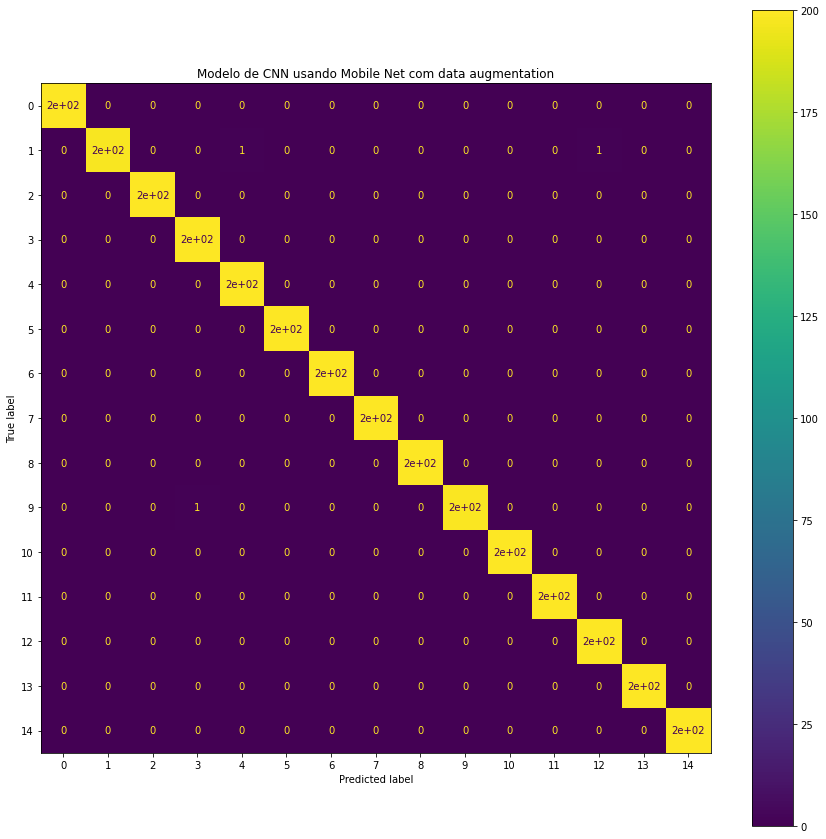

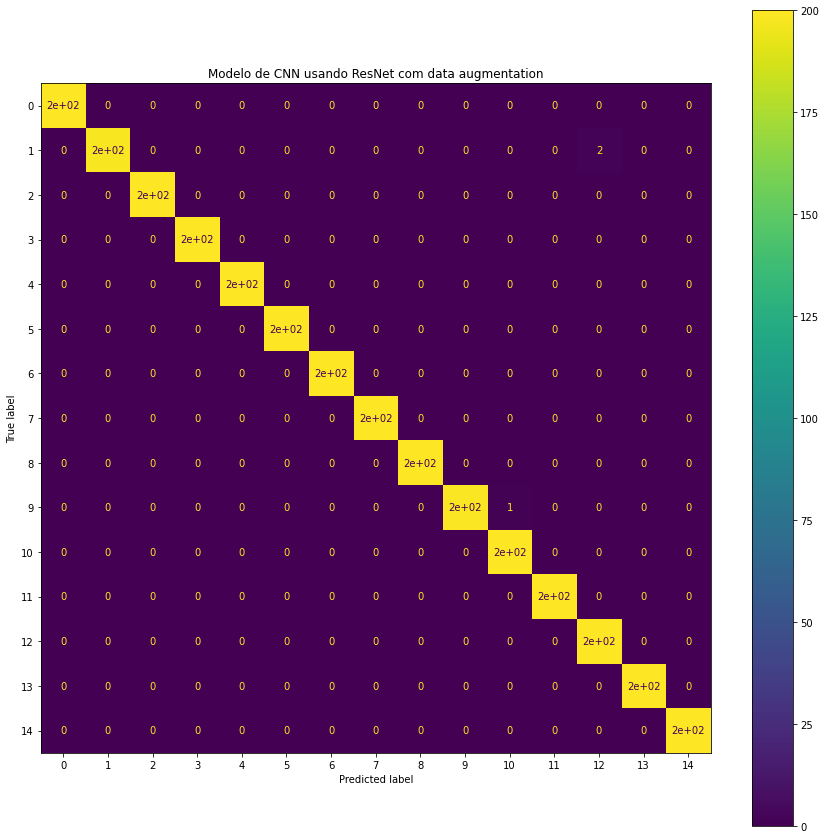

In [ ]:
plotConfusionMatrix(createConfusionMatrix(predicted_cnn_augmented), "Modelo de CNN usando CNN com data augmentation", 'cnn_aug')
plotConfusionMatrix(createConfusionMatrix(predicted_v3_augmented), "Modelo de CNN usando Inception V3 com data augmentation", 'v3_aug')
plotConfusionMatrix(createConfusionMatrix(predicted_vgg16_augmented), "Modelo de CNN usando VGG 16 com data augmentation", 'vgg16_aug')
plotConfusionMatrix(createConfusionMatrix(predicted_mobile_augmented), "Modelo de CNN usando Mobile Net com data augmentation", 'mobile_aug')
plotConfusionMatrix(createConfusionMatrix(predicted_resnet_augmented), "Modelo de CNN usando ResNet com data augmentation", 'resnet_aug')

# Validation

In [ ]:
model_cnn.evaluate(val_image_generator)
model_v3.evaluate(val_image_generator)
model_vgg16.evaluate(val_image_generator)
model_mobile.evaluate(val_image_generator)
model_resnet.evaluate(val_image_generator)

94/94 [==============================] - 10s 87ms/step - loss: 0.0014 - accuracy: 0.9993


[0.001446044072508812, 0.9993333220481873]

In [ ]:
model_cnn_augmented.evaluate(val_image_generator_augmented)
model_v3_augmented.evaluate(val_image_generator_augmented)
model_vgg16_augmented.evaluate(val_image_generator_augmented)
model_mobile_augmented.evaluate(val_image_generator_augmented)
model_resnet_augmented.evaluate(val_image_generator_augmented)

94/94 [==============================] - 35s 363ms/step - loss: 0.0013 - accuracy: 0.9997


[0.0012942287139594555, 0.999666690826416]

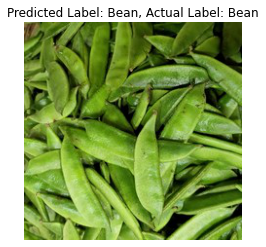

In [ ]:
# Testing the Model
test_image_path = '../content/Vegetable Images/test/Bean/0022.jpg'

def generate_predictions(model, test_image_path, actual_label):
    test_img = image.load_img(test_image_path, target_size=(224, 224))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    predicted_label = np.argmax(model.predict(test_img_input))
    predicted_vegetable = class_map[predicted_label]
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_vegetable, actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()

# call the function
generate_predictions(model_cnn, test_image_path, actual_label='Bean')

In [ ]:
# while True:pass

KeyboardInterrupt: ignored